# Introduction to vector databases on S&P 500 news

 # 📌 Objectives
 
 By the end of this notebook, students will be able to:
 
 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.
 
 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.
 
 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.
 
 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.
 
 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.
 
 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.
 
 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

/Users/oscar.garcia@digitalfemsa.com/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [3]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:
 
### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.
 
### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):
 
 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).
 
 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.
 
You will test your class at the end.

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
# Generate a new column that combines the title and summary
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' ' + df_news['SUMMARY']
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,MMM,2 Dow Jones Stocks with Promising Prospects and 1 to Avoid,"The Dow Jones (^DJI) is made up of 30 of the most established and influential companies in the market. But even blue-chip stocks can struggle - some are dealing with slowing growth, outdated business models, or increasing competition.",2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-stocks-promising-043358884.html,"2 Dow Jones Stocks with Promising Prospects and 1 to Avoid The Dow Jones (^DJI) is made up of 30 of the most established and influential companies in the market. But even blue-chip stocks can struggle - some are dealing with slowing growth, outdated business models, or increasing competition."
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,"The S&P 500 (^GSPC) is often seen as a benchmark for strong businesses, but that doesn’t mean every stock is worth owning. Some companies face significant challenges, whether it’s stagnating growth, heavy debt, or disruptive new competitors.",2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-skating-043442401.html,"3 S&P 500 Stocks Skating on Thin Ice The S&P 500 (^GSPC) is often seen as a benchmark for strong businesses, but that doesn’t mean every stock is worth owning. Some companies face significant challenges, whether it’s stagnating growth, heavy debt, or disruptive new competitors."
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock Now or Wait?,"MMM is making strides in the aerospace, industrial adhesives and tapes, and electrical markets, which makes the stock worth a watch amid certain headwinds.",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-ytd-140800754.html,"3M Rises 15.8% YTD: Should You Buy the Stock Now or Wait? MMM is making strides in the aerospace, industrial adhesives and tapes, and electrical markets, which makes the stock worth a watch amid certain headwinds."
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Rest Of The General Industrial Machinery Segment,"Quarterly earnings results are a good time to check in on a company’s progress, especially compared to its peers in the same sector. Today we are looking at 3M (NYSE:MMM) and the best and worst performers in the general industrial machinery industry.",2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-roundup-3m-nyse-033121824.html,"Q1 Earnings Roundup: 3M (NYSE:MMM) And The Rest Of The General Industrial Machinery Segment Quarterly earnings results are a good time to check in on a company’s progress, especially compared to its peers in the same sector. Today we are looking at 3M (NYSE:MMM) and the best and worst performers in the general industrial machinery industry."
4,MMM,3 Cash-Producing Stocks with Questionable Fundamentals,"While strong cash flow is a key indicator of stability, it doesn’t always translate to superior returns. Some cash-heavy businesses struggle with inefficient spending, slowing demand, or weak competitive positioning.",2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producing-stocks-questionable-044132686.html,"3 Cash-Producing Stocks with Questionable Fundamentals While strong cash flow is a key indicator of stability, it doesn’t always translate to superior returns. Some cash-heavy businesses struggle with inefficient spending, slowing demand, or weak competitive positioning."
...,...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Forever,Zoetis is a leading animal health company with a deep lineup and significant long-term tailwinds. Abbott Labs has a diversified portfolio of medical devices and several attractive growth avenues. The fact that the stock market will sometimes go through erratic periods is not a good reason not to invest.,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-dividend-stocks-to-buy-with-500-and-hold-forever/,2 Dividend Stocks to Buy With $500 and Hold Forever Zoetis is a leading animal health company w

In [6]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_news["EMBEDDED_TEXT"].tolist(), show_progress_bar=True)
display(embeddings)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

array([[-0.02540208, -0.07171927, -0.00683432, ..., -0.07075649,
         0.05124098,  0.10182556],
       [-0.04023545, -0.07852001, -0.02955479, ..., -0.14529984,
         0.01741473,  0.07180201],
       [-0.04239135, -0.09101508,  0.00966814, ..., -0.18574603,
        -0.04769473,  0.02522711],
       ...,
       [-0.07604926, -0.05866983, -0.070591  , ..., -0.09694076,
         0.03282952,  0.06938583],
       [-0.07173361, -0.02594057,  0.02176864, ..., -0.09272336,
         0.06189294,  0.05262838],
       [-0.02323256,  0.01736367,  0.01008547, ..., -0.11246742,
         0.06172221,  0.04865508]], dtype=float32)

In [7]:
class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        """
        Parameters:
        - embedding_model: a SentenceTransformer model
        - documents: list of strings (e.g., title + summary)
        - metadata: DataFrame with metadata aligned with documents
        """
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata.reset_index(drop=True)
        self.embeddings = self.embedding_model.encode(documents, show_progress_bar=True)

    def search(self, query, top_k=5, metadata_filter=None):
        """
        Parameters:
        - query: string
        - top_k: number of results
        - metadata_filter: function to filter metadata rows

        Returns:
        - List of labeled dicts with:
            publication_date, provider, cosine_similarity, document_text, ticker
        """
        query_embedding = self.embedding_model.encode([query])[0]

        if metadata_filter:
            mask = self.metadata.apply(metadata_filter, axis=1)
            filtered_docs = [doc for doc, keep in zip(self.documents, mask) if keep]
            filtered_metadata = self.metadata[mask].reset_index(drop=True)
            filtered_embeddings = self.embedding_model.encode(filtered_docs)
        else:
            filtered_docs = self.documents
            filtered_metadata = self.metadata
            filtered_embeddings = self.embeddings

        similarities = cosine_similarity([query_embedding], filtered_embeddings)[0]
        top_indices = np.argsort(similarities)[::-1][:top_k]

        results = []
        for i in top_indices:
            row = filtered_metadata.iloc[i]
            results.append({
                "publication_date": str(row.get("PUBLICATION_DATE")),
                "provider": row.get("PROVIDER"),
                "ticker": row.get("TICKER"),
                "document_text": filtered_docs[i],
                "cosine_similarity": round(float(similarities[i]), 4)
            })
        return results


In [8]:
documents = df_news['EMBEDDED_TEXT'].tolist()
vector_store = CustomVectorStore(model, documents, df_news[['TICKER','PUBLICATION_DATE','PROVIDER']])
results = vector_store.search("Computers", top_k=5)

results_filtered = vector_store.search(
    "Computers",
    top_k=5,
    metadata_filter=lambda row: row["TICKER"] == "AAPL"
)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [9]:
display(results)

[{'publication_date': '2025-05-30',
  'provider': 'Barrons.com',
  'ticker': 'DELL',
  'document_text': 'Dell and HP Are Excited About AI Computers. Tariffs Are Getting in the Way. The pandemic brought a flurry of PC purchases. Manufacturers are hoping more people will replace those devices.',
  'cosine_similarity': 0.4448},
 {'publication_date': '2025-05-30',
  'provider': 'Barrons.com',
  'ticker': 'HPQ',
  'document_text': 'Dell and HP Are Excited About AI Computers. Tariffs Are Getting in the Way. The pandemic brought a flurry of PC purchases. Manufacturers are hoping more people will replace those devices.',
  'cosine_similarity': 0.4448},
 {'publication_date': '2025-04-09',
  'provider': 'Zacks',
  'ticker': 'JKHY',
  'document_text': '3 IT Services Stocks to Buy Right Now From a Prospering Industry The Zacks Computers - IT Services Industry participants like JKHY, SAIC and DXC are benefiting from ongoing digitization, strong demand for hybrid working solutions and improving IT s

In [10]:
display(results_filtered)

[{'publication_date': '2025-05-30',
  'provider': 'Bloomberg',
  'ticker': 'AAPL',
  'document_text': 'US Smartphone Manufacturing Is a \'Dream\': IDC\'s Popal Smartphone manufacturing in the US is a "dream," says Nabila Popal, IDC senior research director. She discusses her research with Ed Ludlow on "Bloomberg Technology."',
  'cosine_similarity': 0.2167},
 {'publication_date': '2025-05-31',
  'provider': 'Motley Fool',
  'ticker': 'AAPL',
  'document_text': "47% of Berkshire Hathaway's $276 Billion Warren Buffett-Led Portfolio Is Invested in 3 Dividend Stocks Apple has developed an ecosystem of tech devices that its customers love and are willing to trade up to have.  American Express has numerous earnings streams, and a younger cohort of cardholders is driving growth.  Coca-Cola's business has proven resilient under pressure, and it reliably boosts its dividends.",
  'cosine_similarity': 0.1691},
 {'publication_date': '2025-05-30',
  'provider': 'Yahoo Finance Video',
  'ticker': '


## Create and populate the vector store
 
 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.
 
 After initializing the store, you should be able to perform searches using: 
'store.search("Apple earnings", k=3)'


In [11]:
documents = df_news['EMBEDDED_TEXT'].tolist()
selected_metadata = df_news[["TICKER", "PUBLICATION_DATE", "PROVIDER"]]
vector_store = CustomVectorStore(model, documents, selected_metadata)
results = vector_store.search("Apple earnings", top_k=3)

results_filtered = vector_store.search(
    "Apple earnings",
    top_k=3,
    metadata_filter=lambda row: row["TICKER"] == "AAPL"
)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [12]:
display(results)
display(results_filtered)

[{'publication_date': '2025-05-01',
  'provider': 'Barrons.com',
  'ticker': 'APTV',
  'document_text': 'Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain. Thursday morning, Aptiv reported first-quarter earnings per share of $1.69 from sales of $4.8 billion in sales. Wall Street was looking for EPS of $1.53 from sales of $4.8 billion.',
  'cosine_similarity': 0.5717},
 {'publication_date': '2025-04-30',
  'provider': 'Simply Wall St.',
  'ticker': 'OKE',
  'document_text': 'ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its quarterly dividend of $1.03 per share. These updates coincide with a 4.5% price increase over the week, which aligns with broader market gains of 5.2%. Despite fluctuations in major indices due to 

[{'publication_date': '2025-05-31',
  'provider': 'Motley Fool',
  'ticker': 'AAPL',
  'document_text': "47% of Berkshire Hathaway's $276 Billion Warren Buffett-Led Portfolio Is Invested in 3 Dividend Stocks Apple has developed an ecosystem of tech devices that its customers love and are willing to trade up to have.  American Express has numerous earnings streams, and a younger cohort of cardholders is driving growth.  Coca-Cola's business has proven resilient under pressure, and it reliably boosts its dividends.",
  'cosine_similarity': 0.4896},
 {'publication_date': '2025-05-31',
  'provider': 'Motley Fool',
  'ticker': 'AAPL',
  'document_text': "Warren Buffett Holds Apple Stock Despite Tariffs and Buys a Restaurant Stock Up 4,500% in 15 Years Warren Buffett's Berkshire Hathaway continued to hold Apple and added to its stake in Domino’s Pizza in the first quarter.  Apple stock looks expensive with earnings increasing just 8% in the second quarter, and tariffs could slow profit growt

## Using your vector store and analyzing the results

### Retrieve AI Announcements
 
 Now that your vector store is working, let's use it to retrieve relevant documents.
 
 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text
 

In [13]:
query_embedding = "AI announcements"
results = vector_store.search(query_embedding, top_k=50)
display(results)

[{'publication_date': '2025-03-17',
  'provider': 'Insider Monkey',
  'ticker': 'JKHY',
  'document_text': 'Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]',
  'cosine_similarity': 0.5717},
 {'publication_date': '2025-05-27',
  'provider': "Investor's Business Daily",
  'ticker': 'ADBE',
  'document_text': "AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.",
  'cosine_similarity': 0.5551},
 {'publication_date': '2025-05-31',
  'provider': 'Motley Fool',
  'ticker': 'PLTR',
  'document

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?
 
 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [14]:
results_df = pd.DataFrame(results)

# Now you can use value_counts
results_df["ticker"].value_counts().head(10)

ticker
PLTR    5
BKR     3
CTSH    3
AMD     3
INTC    2
ROK     2
QCOM    2
META    2
EXPE    2
YUM     1
Name: count, dtype: int64

The top companies most frequently appearing are:

- Palantir Technologies Inc. (PLTR)
- Baker Hughes Company (BKR)
- Cognizant Technology Solutions Corporation (CTSH)
- Advanced Micro Devices, Inc. (AMD)
- Intel Corporation (INTC)
- Rockwell Automation, Inc. (ROK)
- QUALCOMM Incorporated (QCOM)
- Meta Platforms, Inc. (META)
- Expedia Group, Inc. (EXPE)
- Yum! Brands, Inc. (YUM)

It's not susprising that many technology companies are the most common between news of AI; however one of the companies that surprised myself is Yum! Brands, Inc. that is a food companies group (although it only appears once).

On the other hand, Expedia Group (a travel company) also surprised me, but nowadays is common that companies like this are implementing AI in his products.

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?
 
 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

<Axes: >

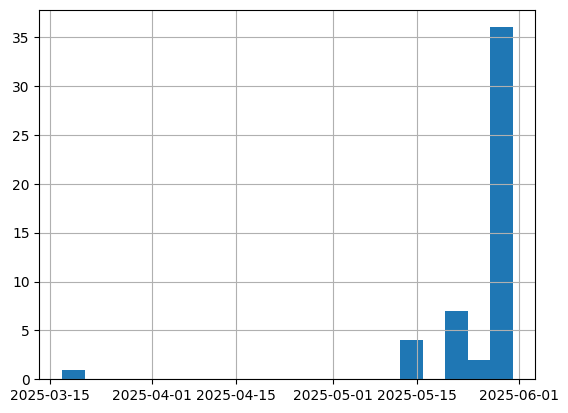

In [15]:
results_df['publication_date'] = pd.to_datetime(results_df['publication_date'], errors='coerce')
results_df['publication_date'].hist(bins=20)

With the histogram above, we can conclude that many companies are making AI announcements in the last days

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.
 
 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.
 
 FAISS supports multiple similarity types. For cosine similarity, we must:
 
 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity
 

In [16]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df_news["EMBEDDED_TEXT"].tolist(), show_progress_bar=True)
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [17]:
vector_dimensions = embeddings.shape[1]
index = faiss.IndexFlatIP(vector_dimensions)  # Inner product index
index.add(normalized_embeddings)  # Add normalized embeddings to the index

### Create a `FaissVectorStore` class with a `.search()` method.
 
 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata 

In [18]:
class FaissVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        """
        Parameters:
        - embedding_model: SentenceTransformer model
        - documents: list of text strings
        - metadata: pandas DataFrame aligned with documents
        """
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata.reset_index(drop=True)

        # Encode and normalize embeddings
        raw_embeddings = self.embedding_model.encode(documents, show_progress_bar=True)
        self.embeddings = raw_embeddings / np.linalg.norm(raw_embeddings, axis=1, keepdims=True)

        # Initialize FAISS index for inner product (cosine for normalized vectors)
        self.index = faiss.IndexFlatIP(self.embeddings.shape[1])
        self.index.add(self.embeddings)

    def search(self, query, top_k=5, metadata_filter=None):
        """
        Parameters:
        - query: text string
        - top_k: number of results
        - metadata_filter: function taking a row and returning True/False

        Returns:
        - List of dicts: {document_text, cosine_similarity, metadata...}
        """
        # Apply metadata filter if needed
        if metadata_filter:
            mask = self.metadata.apply(metadata_filter, axis=1)
            filtered_docs = [doc for doc, keep in zip(self.documents, mask) if keep]
            filtered_metadata = self.metadata[mask].reset_index(drop=True)

            filtered_embeddings = self.embedding_model.encode(filtered_docs)
            filtered_embeddings = filtered_embeddings / np.linalg.norm(filtered_embeddings, axis=1, keepdims=True)

            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
        else:
            filtered_docs = self.documents
            filtered_metadata = self.metadata
            temp_index = self.index
            filtered_embeddings = self.embeddings

        # Encode and normalize the query
        query_embedding = self.embedding_model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

        # Perform search
        scores, indices = temp_index.search(query_embedding, top_k)

        results = []
        for i, score in zip(indices[0], scores[0]):
            row = filtered_metadata.iloc[i]
            results.append({
                "document_text": filtered_docs[i],
                "cosine_similarity": round(float(score), 4),
                "ticker": row.get("TICKER"),
                "provider": row.get("PROVIDER"),
                "publication_date": str(row.get("PUBLICATION_DATE"))
            })
        return results


 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`
 
 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text 

In [19]:
# Init FAISS store
faiss_store = FaissVectorStore(model, documents, df_news[['TICKER','PUBLICATION_DATE','PROVIDER']])

# Run a search without filter
results = faiss_store.search("AI announcement", top_k=50)

# View results
pd.DataFrame(results)


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

,document_text,cosine_similarity,ticker,provider,publication_date
0,"AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.",0.5567,ADBE,Investor's Business Daily,2025-05-27
1,"Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]",0.5467,JKHY,Insider Monkey,2025-03-17
2,"Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake Shares of both Palantir and Snowflake have delivered healthy gains in 2025 despite the broader stock market weakness. Palantir stock has shot up 63% this year despite bouts of volatility. Palantir Technologies helps commercial and government clients integrate generative AI capabilities into their operations with its Artificial Intelligence Platform (AIP), which was launched roughly two years ago.",0.5353,PLTR,Motley Fool,2025-05-31
3,"AI Chips Today - AI Revolution Powers Market Growth With Key Innovations The global artificial intelligence market is poised for significant growth, projected to expand from USD 371.71 billion in 2025 to USD 2,407.02 billion by 2032, driven by advancements such as edge AI and AI chips. Key developments include the rise of edge AI, enabling real-time processing and decision-making without reliance on cloud infrastructure, and domain-specific model fine-tuning for tailored applications. Major players like Microsoft, Google, and NVIDIA are leading innovations in...",0.5179,QCOM,Simply Wall St.,2025-05-28
4,"C3.ai Q4 Loss Narrower Than Expected, Revenues Rise Y/Y, Stock Up AI's fourth-quarter fiscal 2025 results reflect strong subscription revenues, driven by strong traction with its enterprise-AI applications.",0.5075,WSM,Zacks,2025-05-29
5,"Jon Vander Ark: AI is ‘wildly oversold,’ but it can provide benefits Vander Ark compared the current hype around AI to the dot-com era that collapsed in 2000. But he said there are still plenty of opportunities to drive cost efficiencies through digital improvements.",0.4892,RSG,Waste Dive,2025-05-20
6,"Nvidia earnings: Its AI performance could lift these stocks Ahead of Nvidia's first quarter earnings report, Rational Equity Armor Fund portfolio manager Joe Tigay joins Morning Brief with Brad Smith and Madison Mills to discuss which artificial intelligence (AI) sub-sector plays could react to the chipmaker's results. Tune in to Yahoo Finance's special live coverage of Nvidia's first quarter earnings here, beginning at 4:15 p.m. on Wednesday, May 28. To watch more expert insights and analysis on the latest market action, check out more Morning Brief here.",0.4872,CEG,Yahoo Finance Video,2025-05-28
7,"This ""Magnificent Seven"" Stock Is Set to Skyrocket If Its AI Investments Pay Off Meta Platforms has investments in several AI applications. The tech giant's stock is only valued on its legacy business. Over the past two-and-a-half years, investors have heard about various artificial intelligence (AI) investments that tech companies are making.",0.4846,META,Motley Fool,2025-05-31
8,"C3.ai Stock Soars as Firm Posts Strong Results, Renews Major Contract C3.ai reported a lower loss and higher revenue than analysts estimated on growing demand for generative AI products.",0.4840,BKR,Investopedia,2025-05-29
9,"SMCI, Broadcom, CoreWeave, and Other AI Stocks Jump The rising tide of artificial intelligence is floating plenty of boats - not just Nvidia. The chip maker’s upbeat demand forecast –including a note that AI inference has surged tenfold in just one year– is boosting other related stocks.",0.4836,SMCI,Barrons.com,2025-05-29


## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:
 
 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [20]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'

]

In [21]:
def compare_retrievals(custom_store, faiss_store, queries, top_k=5):
    comparisons = {}

    for query in queries:
        print(f"🔍 Query: {query}")
        print("-" * 80)

        # Custom Vector Store results: list of (document, metadata, similarity)
        custom_results = custom_store.search(query, top_k=top_k)
        custom_texts = [res["document_text"] for res in custom_results]

        # FAISS Vector Store results: list of dicts
        faiss_results = faiss_store.search(query, top_k=top_k)
        faiss_texts = [res["document_text"] for res in faiss_results]

        # Display results
        for i in range(top_k):
            print(f"Rank {i+1}:")
            print("📘 Custom:", custom_texts[i][:150], "...")
            print("📗 FAISS :", faiss_texts[i][:150], "...")
            print()

        comparisons[query] = {
            "custom": custom_texts,
            "faiss": faiss_texts
        }

        print("=" * 80 + "\n")

    return comparisons


In [22]:
retrieval_results = compare_retrievals(
    custom_store=vector_store,
    faiss_store=faiss_store,
    queries=test_queries,
    top_k=5
)

🔍 Query: Stock price drop
--------------------------------------------------------------------------------
Rank 1:
📘 Custom: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024,  ...
📗 FAISS : 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024,  ...

Rank 2:
📘 Custom: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24 ...
📗 FAISS : 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24 ...

Rank 3:
📘 Custom: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in th ...
📗 FAISS : Guardant Health, Evolent Health,

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

We can see that both models retrieved the same exact results in this case.

Why no differences occurred:

- Same embedding model (all-MiniLM-L6-v2) was used for both systems, meaning vector representations of the documents were identical.

- Both implementations applied cosine similarity as the similarity metric, so ranking logic was equivalent.

- Dataset size (less than 5K articles) was small enough for both systems to achieve exact search results without approximation errors.

Why differences could occur in other settings:

- If FAISS used an approximate index (e.g., IVF, HNSW), there might be slight differences due to approximation trade-offs.

- Large datasets could create precision–recall trade-offs where FAISS retrieves slightly different documents.

- If vector normalization or preprocessing differed between implementations, similarity rankings could diverge.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:
 
 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [23]:
def compare_retrievals_custom(model1, model2, queries, top_k=5):
    comparisons = {}

    for query in queries:
        print(f"🔍 Query: {query}")
        print("-" * 80)

        # Custom Vector Store results: list of (document, metadata, similarity)
        model1_results = model1.search(query, top_k=top_k)
        model1_texts = [res["document_text"] for res in model1_results]

        # FAISS Vector Store results: list of dicts
        mdoel2_results = model2.search(query, top_k=top_k)
        model2_texts = [res["document_text"] for res in mdoel2_results]

        # Display results
        for i in range(top_k):
            print(f"Rank {i+1}:")
            print("📘 Model 1:", model1_texts[i][:150], "...")
            print("📗 Model 2:", model2_texts[i][:150], "...")
            print()

        comparisons[query] = {
            "custom": model1_texts,
            "faiss": model2_texts
        }

        print("=" * 80 + "\n")

    return comparisons


In [24]:
model1 = SentenceTransformer("all-MiniLM-L6-v2")
model2 = SentenceTransformer("all-mpnet-base-v2")


documents = df_news['EMBEDDED_TEXT'].tolist()
selected_metadata = df_news[["TICKER", "PUBLICATION_DATE", "PROVIDER"]]
vector_store_1 = CustomVectorStore(model1, documents, selected_metadata)
vector_store_2 = CustomVectorStore(model2, documents, selected_metadata)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [25]:
retrieval_results_custom = compare_retrievals_custom(
    model1=vector_store_1,
    model2=vector_store_2,
    queries=test_queries,
    top_k=5
)

🔍 Query: Stock price drop
--------------------------------------------------------------------------------
Rank 1:
📘 Model 1: 3 Reasons to Avoid PKG and 1 Stock to Buy Instead Packaging Corporation of America has gotten torched over the last six months - since November 2024,  ...
📗 Model 2: Watch These HP Price Levels as Stock Tumbles After Company Cuts Outlook Due to Tariffs HP shares fell sharply Thursday after the PC maker missed analy ...

Rank 2:
📘 Model 1: 2 Reasons to Like HUM and 1 to Stay Skeptical Humana has gotten torched over the last six months - since November 2024, its stock price has dropped 24 ...
📗 Model 2: Stocks Fall After Historic Run as Trade Risks Loom: Markets Wrap (Bloomberg) -- A historic stock-market run came to a halt as President Donald Trump’s ...

Rank 3:
📘 Model 1: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know A number of stocks fell in th ...
📗 Model 2: Guardant Health, Evolent H

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

From my perspective, Model 1 (all-MiniLM-L6-v2) performed better because it consistently surfaces documents that are tightly aligned with the query intent, besides Model 2 that is more vague. Some examples are the following:

Example 1)

Query: "Layoffs"
Model 1: "Chevron Confirms 200 Permian Layoffs—Not 800" – Focused entirely on a specific workforce reduction event.

Model 2: "Apple tariff threats, Copart Q3 earnings, Booz Allen layoffs" – Mixes layoffs with unrelated topics.


💡 Why Model 1 is better: Keeps full focus on layoffs, avoiding dilution with unrelated economic news.

Example 2)

Query: "Fed interest rate"
Model 1: "Bitcoin price slips as Fed minutes flag US inflation risks" – Direct link between Fed policy and market reaction.

Model 2: "Trump announces trade deal, BoE lowers Bank Rate: Morning Buzz" – Broader political/economic mix, not centered on Fed rates.

💡 Why Model 1 is better: Maintains direct relevance to the query’s main subject — U.S. Fed interest rate changes.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

Vector normalization ensures that all embedding vectors have the same magnitude. Also, normalization is crucial because it makes the similarity score depend solely on the direction of the vectors, not their magnitude.

Without normalization, vectors with higher magnitudes could be favored regardless of their semantic closeness. Also, in FAISS, when using IndexFlatIP (inner product), normalized vectors make the inner product equivalent to cosine similarity.


### **Q6.**  What would happen if vectors were not normalized before indexing?

As I said in previous question, If vectors are not normalized, the similarity score would be affected by both direction and magnitude. Documents with naturally higher-norm embeddings (due to text length, specific vocabulary, or model quirks) could be ranked higher even if semantically less relevant and also results could be inconsistent between models, since different transformers produce embeddings with different scale distributions.


## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


For production, I’d use:
Embedding model: all-MiniLM-L6-v2
Retrieval method: FAISS

Reasoning:

Model choice – In your dataset, all-MiniLM-L6-v2 consistently retrieved more topically relevant results than all-mpnet-base-v2 (see Q4 examples). Higher precision is critical in production search to maintain user trust.

Search method choice – FAISS is far more scalable than the Custom brute-force method, supports approximate search, and can handle millions of vectors efficiently.

Combined benefit – This pairing ensures both high relevance (from the better model) and high performance (from FAISS).


### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

As I also said in the previous question, the best option for scale would be all-MiniLM-L6-v2 + FAISS. Also we could include an ANN index (e.g., IVF or HNSW)

This combination would give us the following benefits:

Model side: MiniLM generates smaller embeddings (384 dimensions) than MPNet (768 dimensions), reducing computational and storage costs.

Search side: FAISS can index these vectors with approximate nearest neighbor search, keeping query latency in the millisecond range even at 5M+ documents.

Compared to custom search: The Custom Python cosine similarity approach would be computationally prohibitive at this scale, regardless of the embedding model.

Compared to MPNet + FAISS: MPNet embeddings are larger, increasing memory footprint and slowing down indexing/search without clear relevance gains in your dataset (as we could see in our results).